<a name="pagetop"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Plotting Satellite Data</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 500px;"></div>

### Questions
1. Where are current GOES data available?
1. How can satellite data be obtained with Siphon?
1. How can maps be made with the declarative plotting interface?

### Table of Contents
1. <a href="#findingdata">Finding GOES data</a>
1. <a href="#dataaccess">Accessing data with Siphon</a>
1. <a href="#plotting">Plotting the data</a>
1. <a href="#subplots">How Subplots Work</a>
1. <a href="#annotations">Adding Annotations</a>

<hr style="height:2px;">

<a name="findingdata"></a>
## Finding GOES Data

The first step is to find the satellite data. Normally, we would browse over to http://thredds.ucar.edu/thredds/ and find the top-level [THREDDS Data Server (TDS)](https://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html) catalog. From there we can drill down to find satellite data products.

For current data, you could navigate to the `Satellite Data` directory, then `GOES East Products` and `CloudAndMoistureImagery`. There are subfolders for the CONUS, full disk, mesoscale sector images, and other products. In each of these is a folder for each [channel of the ABI](https://www.goes-r.gov/mission/ABI-bands-quick-info.html). In each channel there is a folder for every day in the approximately month-long rolling archive. As you can see, there are a massive amount of data coming down from GOES-16!

In the next section we'll be downloading the data in a pythonic way, so our first task is to build a URL that matches the URL we manually navigated to in the web browser. To make it as flexible as possible, we'll want to use variables for the sector name (CONUS, full-disk, mesoscale-1, etc.), the date, and the ABI channel number.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li>Create variables named image_date, region, and channel. Assign them to today's date, the mesoscale-1 region, and ABI channel 8. </li>
         <li>Construct a string data_url from these variables and the URL we navigated to above.</li>
         <li>Verify that following your link will take you where you think it should.</li>
         <li>Change the extension from catalog.html to catalog.xml. What do you see?</li>
    </ul>
</div>

In [1]:
from datetime import datetime

# Create variables for URL generation
# YOUR CODE GOES HERE

# Construct the data_url string
# YOUR CODE GOES HERE

# Print out your URL and verify it works!
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [2]:
# %load solutions/data_url.py

# Cell content replaced by load magic replacement.
from datetime import datetime

# Create variables for URL generation
image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 8

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string
data_url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
            f'{image_date:%Y%m%d}/catalog.xml')

# Print out your URL and verify it works!
print(data_url)


https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel08/20200111/catalog.xml


<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="dataaccess"></a>
## Accessing data with Siphon

We could download the files to our computers from the THREDDS web interface, but that can become tedious for downloading many files, requires us to store them on our computer, and does not lend itself to automation.

We can use [Siphon](https://github.com/Unidata/siphon) to parse the catalog from the TDS. This provides us a nice programmatic way of accessing the data. We start by importing the `TDSCatalog` class from siphon and giving it the URL to the catalog we just surfed to manually. **Note:** Instead of giving it the link to the HTML catalog, we change the extension to XML, which asks the TDS for the XML version of the catalog. This is much better to work with in code. If you forget, the extension will be changed for you, but siphon will issue a warning.

We want to create a `TDSCatalog` object called `cat` that we can examine and use to get handles to work with the data.

In [3]:
from siphon.catalog import TDSCatalog

In [4]:
image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 8

data_url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
            f'{image_date:%Y%m%d}/catalog.xml')

cat = TDSCatalog(data_url)

To find the latest file, we can look at the `cat.datasets` attribute. Let’s look at the first five datasets:

In [5]:
cat.datasets[:5]

[OR_ABI-L2-CMIPC-M6C08_G16_s20200112211170_e20200112211170_c20200112211170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20200112206170_e20200112206170_c20200112206170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20200112201170_e20200112201170_c20200112201170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20200112156170_e20200112156170_c20200112156170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20200112151170_e20200112151170_c20200112151170.nc]

In [6]:
cat.datasets[0]

OR_ABI-L2-CMIPC-M6C08_G16_s20200112211170_e20200112211170_c20200112211170.nc

We'll get the next to most recent dataset (sometimes the most recent will not have received all tiles yet) and store it as variable `dataset`. Note that we haven't actually downloaded or transferred any real data yet, just bits of metadata have been received from THREDDS and parsed by siphon.

In [7]:
dataset = cat.datasets[1]

In [8]:
print(dataset)

OR_ABI-L2-CMIPC-M6C08_G16_s20200112206170_e20200112206170_c20200112206170.nc


We're finally ready to get the actual data. We could download the file, then open that, but there is no need! We can use siphon to help us only get what we need and hold it in memory. Notice that we're using the XArray accessor which will make life much nicer that dealing with the raw netCDF (like we used to back in the days of early 2018).

In [9]:
ds = dataset.remote_access(use_xarray=True)

Now that we've got some data - let's see what we actually got our hands on.

In [10]:
ds

<xarray.Dataset>
Dimensions:               (x: 2500, y: 1500)
Coordinates:
    time                  datetime64[ns] ...
  * y                     (y) float32 128212.0 128156.0 ... 44324.0 44268.0
  * x                     (x) float32 -101332.0 -101276.0 ... 38556.0 38612.0
Data variables:
    Sectorized_CMI        (y, x) float32 ...
    fixedgrid_projection  int32 ...
Attributes:
    title:                       Sectorized Cloud and Moisture Imagery for th...
    ICD_version:                 GROUND SEGMENT (GS) TO ADVANCED WEATHER INTE...
    Conventions:                 CF-1.6
    channel_id:                  8
    central_wavelength:          6.19
    abi_mode:                    6
    source_scene:                CONUS
    periodicity:                 5.0
    production_location:         RBU
    product_name:                ECONUS-020-B12-M6C08
    satellite_id:                GOES-16
    product_center_latitude:     30.08300267372796
    product_center_longitude:    -87.09695844824527
    projection:                  Fixed Grid
    bit_depth:                   12
    source_spatial_resolution:   2.0
    request_spatial_resolution:  2.0
    start_date_time:             2020011220617
    number_product_tiles:        15
    product_tile_width:          512
    product_tile_height:         512
    product_rows:                1500
    product_columns:             2500
    pixel_x_size:                2.0
    pixel_y_size:                2.0
    satellite_latitude:          0.0
    satellite_longitude:         -75.0
    satellite_altitude:          35786023.0
    created_by:                  ldm-alchemy
    product_tiles_received:      15

Great, so we have an XArray Dataset object, something we've dealt with before! We also see that we have the coordinates `time`, `y`, and `x` as well as the data variables of `Sectorized_CMI` and the projection information. MetPy has tools to make parsing all of this much easier than it used to be, but when using the delcarative plotting syntax, everything happens "automagically" for you and you don't need to worry about coordinate systems!

<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="plotting"></a>
## Plotting the Data

When using the declarative plotting syntax, we need to import XArray and the plotting tools we'll use from MetPy. If you're used to working with Matplotlib - here's how the declarative objects should map in your thinking:

| Matplotlib | Declarative Plotting | Description |
| ---------- | -------------------- | ----------- |
| Figure     | Panel Container      | Place to draw one or more plots |
| Axes       | Panel (multiple kinds) | A set of x-y places to draw data inside a figure/panel container |
| Plotting Methods | Plotting Methods | Methods that draw data on an axes/panel in various ways (line plot, contours, images, etc). |

For satellite data, we'd use `imshow` in matplotlib, but with the declarative syntax we want to make an `ImagePlot`.

In [11]:
import xarray as xr

from metpy.plots.declarative import *

First, let's make the image plot. We create an instance of it and name it, then set the data we want to use (our XArray data array) and the field from that data array we want to plot (Sectorized_CMI in this case).

In [12]:
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'

Now we want to build a panel for that data to go in. Since the data are georeferenced, we'll use a `MapPanel`.

In [13]:
panel = MapPanel()
panel.plots = [img]

Finally, we want to build a panel container (figure) for the panel(s) to go in. Here we just have one panel.

In [14]:
pc = PanelContainer()
pc.panels = [panel]

Show the results of our "hard" work!

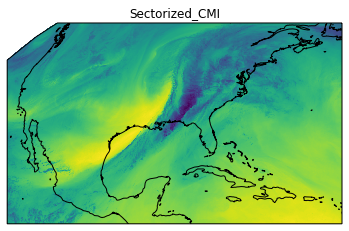

In [15]:
pc.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li> Now it's your turn! Set the colormap attribute of the ImagePlot to an appropriate colortable from those in metpy.plots.colortables <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html">here</a>.</li>
         <li>Using the title attribute of the MapPanel, give the plot a meaningful title.</li>
         <li>Set the size attribute on the PanelContainer to a tuple representing the image size in the format (x, y).</li>
    </ul>
</div>

In [16]:
# Create the ImagePlot
# YOUR CODE GOES HERE

# Create the MapPanel
# YOUR CODE GOES HERE

# Create the PanelContainer
# YOUR CODE GOES HERE

# Show it!
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

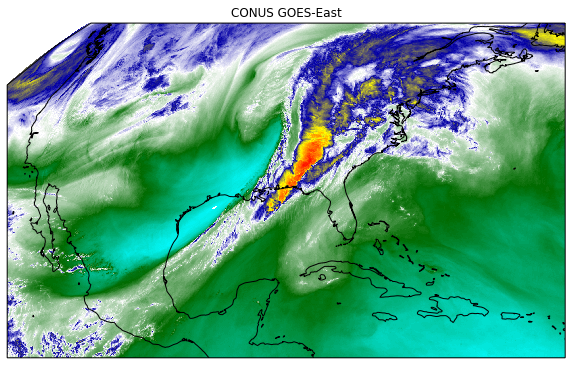

In [17]:
# %load solutions/dec_map_modifications.py

# Cell content replaced by load magic replacement.
# Create the ImagePlot
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'WVCIMSS'

# Create the MapPanel
panel = MapPanel()
panel.plots = [img]
panel.title = "CONUS GOES-East"

# Create the PanelContainer
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)

# Show it!
pc.show()


<a name="subplots"></a>
## How Subplots Work

<div class="alert alert-success">
    <b>EXERCISE</b>:
    
Now that you're familiar with the basic workflow of getting some satellite data and creating a plot, this is a challenge exercise to extend and combine those ideas.
     <ul>
         <li>Create a two panel plot (one PanelContainer, two MapPanels, two ImagePlots) with band 7 (IR) and band 9 (Mid-Level Water Vapor).</li>
         <li>Set the layout attribute on the left panel to (2, 1, 1) and on the right to (2, 1, 2)</li>
         <li>Add both panels to the PanelContainer</li>
         <li>Label the plots</li>
         <li>Apply appropriate color maps</li>
    </ul>
    
<i>Remember: build from the smallest component (the ImagePlot) to the biggest (the PanelContainer).</i>

<b>BONUS: Functionalize this to eliminate repeated code!</b>
</div>

In [18]:
#
# Get the data
#

# Get the data for band 7
# YOUR CODE GOES HERE

# Get the data for band 10
# YOUR CODE GOES HERE

#
# Make the plot
#
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

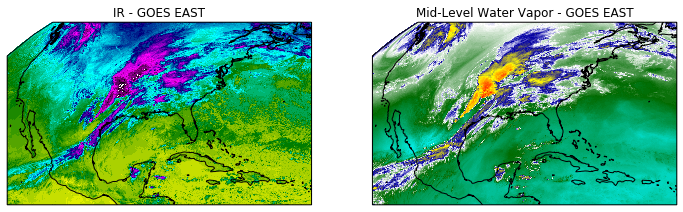

In [19]:
# %load solutions/dec_map_multipanel.py

# Cell content replaced by load magic replacement.
#
# Get the data
#

# Get the data for band 7
url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel07/'
            f'{datetime.utcnow():%Y%m%d}/catalog.xml')
cat = TDSCatalog(url)
band_7 = cat.datasets[-2].remote_access(use_xarray=True)

# Get the data for band 10
url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel10/'
            f'{datetime.utcnow():%Y%m%d}/catalog.xml')
cat = TDSCatalog(url)
band_10 = cat.datasets[-2].remote_access(use_xarray=True)

#
# Make the plot
#
band_7_img = ImagePlot()
band_7_img.data = band_7
band_7_img.field = 'Sectorized_CMI'
band_7_img.colormap = 'ir_rgbv'

band_10_img = ImagePlot()
band_10_img.data = band_10
band_10_img.field = 'Sectorized_CMI'
band_10_img.colormap = 'WVCIMSS'

left_panel = MapPanel()
left_panel.plots = [band_7_img]
left_panel.title = 'IR - GOES EAST'
left_panel.layout = (1, 2, 1)

right_panel = MapPanel()
right_panel.plots = [band_10_img]
right_panel.title = 'Mid-Level Water Vapor - GOES EAST'
right_panel.layout = (1, 2, 2)

pc = PanelContainer()
pc.panels = [left_panel, right_panel]
pc.size = (12, 10)

pc.show()


<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

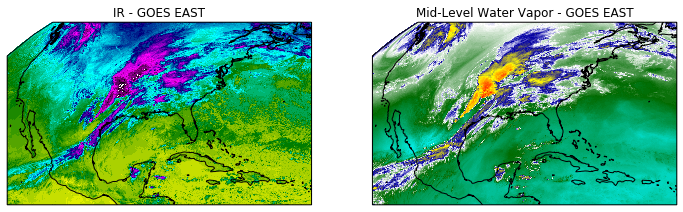

In [20]:
# %load solutions/dec_map_multipanel_bonus.py

# Cell content replaced by load magic replacement.
def make_channel_image_plot(channel):
    url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
                f'{datetime.utcnow():%Y%m%d}/catalog.xml')
    cat = TDSCatalog(url)
    band_data = cat.datasets[-2].remote_access(use_xarray=True)
    
    img = ImagePlot()
    img.data = band_data
    img.field = 'Sectorized_CMI'
    return img

#
# Make the plot
#
band_7_img = make_channel_image_plot(7)
band_10_img = make_channel_image_plot(10)

band_7_img.colormap = 'ir_rgbv'
band_10_img.colormap = 'WVCIMSS'

left_panel = MapPanel()
left_panel.plots = [band_7_img]
left_panel.title = 'IR - GOES EAST'
left_panel.layout = (1, 2, 1)

right_panel = MapPanel()
right_panel.plots = [band_10_img]
right_panel.title = 'Mid-Level Water Vapor - GOES EAST'
right_panel.layout = (1, 2, 2)

pc = PanelContainer()
pc.panels = [left_panel, right_panel]
pc.size = (12, 10)

pc.show()


<a name="annotations"></a>
## Adding Annotations
Often we want to add some other things to our maps - geographic boundaries, time stamps, logos, etc.

Let's start by setting the geographic region of the plot and adding some geographic features. 

Geographic features can be added by setting *layers*. The available layers are:
* coastline
* states
* borders
* lakes
* land
* ocean
* rivers

The region is set using *area* - a tuple or string value. The tuple lets you set longitude/latitude box based on the projection of the map *(west-most, east-most, south-most, north-most)*. The region can also be set to a string that represents preset areas. These areas include:

| Region | Bounds | Region | Bounds | Region | Bounds | Region | Bounds |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| 105 | -129.3, -22.37, 17.52, 53.78 | local | -92.0, -64.0, 28.5, 48.5 | wvaac | 120.86, -15.07, -53.6, 89.74 | tropsfc | -100.0, -55.0, 8.0, 33.0 |
| epacsfc | -155.0, -75.0, -20.0, 33.0 | ofagx | -100.0, -80.0, 20.0, 35.0 | ahsf | -105.0, -30.0, -5.0, 35.0 | ehsf | -145.0, -75.0, -5.0, 35.0 |
| shsf | -125.0, -75.0, -20.0, 5.0 | tropful | -160.0, 0.0, -20.0, 50.0 | tropatl | -115.0, 10.0, 0.0, 40.0 | subtrop | -90.0, -20.0, 20.0, 60.0 |
| troppac | -165.0, -80.0, -25.0, 45.0 | gulf | -105.0, -70.0, 10.0, 40.0 | carib | -100.0, -50.0, 0.0, 40.0 | sthepac | -170.0, -70.0, -60.0, 0.0 |
| opcahsf | -102.0, -20.0, 0.0, 45.0 | opcphsf | 175.0, -70.0, -28.0, 45.0 | wwe | -106.0, -50.0, 18.0, 54.0 | world | -24.0, -24.0, -90.0, 90.0 |
| nwwrd1 | -180.0, 180.0, -90.0, 90.0 | nwwrd2 | 0.0, 0.0, -90.0, 90.0 | afna | -135.02, -23.04, 10.43, 40.31 | awna | -141.03, -18.58, 7.84, 35.62 |
| medr | -178.0, -25.0, -15.0, 5.0 | pacsfc | 129.0, -95.0, -5.0, 18.0 | saudi | 4.6, 92.5, -13.2, 60.3 | natlmed | -30.0, 70.0, 0.0, 65.0 |
| ncna | -135.5, -19.25, 8.0, 37.7 | ncna2 | -133.5, -20.5, 10.0, 42.0 | hpcsfc | -124.0, -26.0, 15.0, 53.0 | atlhur | -96.0, -6.0, 4.0, 3.0 |
| nam | -134.0, 3.0, -4.0, 39.0 | sam | -120.0, -20.0, -60.0, 20.0 | samps | -148.0, -36.0, -28.0, 12.0 | eur | -16.0, 80.0, 24.0, 52.0 |
| afnh | -155.19, 18.76, -6.8, -3.58 | awnh | -158.94, 15.35, -11.55, -8.98 | wwwus | -127.7, -59.0, 19.8, 56.6 | ccfp | -130.0, -65.0, 22.0, 52.0 |
| llvl | -119.6, -59.5, 19.9, 44.5 | llvl2 | -125.0, -32.5, 5.0, 46.0 | llvl_e | -89.0, -59.5, 23.5, 44.5 | llvl_c | -102.4, -81.25, 23.8, 51.6 |
| llvl_w | -119.8, -106.5, 19.75, 52.8 | ak_artc | 163.7, -65.3, 17.5, 52.6 | fxpswna | -80.5, 135.0, -1.0, 79.0 | fxpsnna | -80.5, 54.0, -1.0, 25.5 |
| fxpsna | -72.6, 31.4, -3.6, 31.0 | natl_ps | -80.5, 54.0, -1.0, 25.5 | fxpsena | -45.0, 54.0, 11.0, 25.5 | fxpsnp | 155.5, -106.5, 22.5, 47.0 |
| npac_ps | 155.5, -106.5, 22.5, 47.0 | fxpsus | -120.0, -59.0, 20.0, 44.5 | fxmrwrd | 58.0, 58.0, -70.0, 70.0 | fxmrwr2 | -131.0, -131.0, -70.0, 70.0 |
| nwmrwrd | 70.0, 70.0, -70.0, 70.0 | wrld_mr | 58.0, 58.0, -70.0, 70.0 | fxmr110 | -180.0, -110.0, -20.0, 50.5 | fxmr180 | 110.0, -180.0, -20.0, 50.5 |
| fxmrswp | 97.5, -147.5, -36.0, 45.5 | fxmrus | -162.5, -37.5, -28.0, 51.2 | fxmrea | -40.0, 20.0, -20.0, 54.2 | fxmrjp | 100.0, -160.0, 0.0, 45.0 |
| icao_a | -137.4, -12.6, -54.0, 67.0 | icao_b | -52.5, -16.0, -62.5, 77.5 | icao_b1 | -125.0, 40.0, -45.5, 62.7 | icao_c | -35.0, 70.0, -45.0, 75.0 |
| icao_d | -15.0, 132.0, -27.0, 63.0 | icao_e | 25.0, 180.0, -54.0, 40.0 | icao_f | 100.0, -110.0, -52.7, 50.0 | icao_g | 34.8, 157.2, -0.8, 13.7 |
| icao_h | -79.1, 56.7, 1.6, 25.2 | icao_i | 166.24, -60.62, -6.74, 33.32 | icao_j | 106.8, -101.1, -27.6, 0.8 | icao_k | 3.3, 129.1, -11.1, 6.7 |
| icao_m | 100.0, -110.0, -10.0, 70.0 | icao_eu | -21.6, 68.4, 21.4, 58.7 | icao_me | 17.0, 70.0, 10.0, 44.0 | icao_as | 53.0, 108.0, 0.0, 36.0 |
| icao_na | -54.1, 60.3, 17.2, 50.7 | nhem | -135.0, 45.0, -15.0, -15.0 | nhem_ps | -135.0, 45.0, -15.0, -15.0 | nhem180 | 135.0, -45.0, -15.0, -15.0 |
| nhem155 | 160.0, -20.0, -15.0, -15.0 | nhem165 | 150.0, -30.0, -15.0, -15.0 | nh45_ps | -90.0, 90.0, -15.0, -15.0 | nhem0 | -45.0, 135.0, -15.0, -15.0 |
| shem_ps | 88.0, -92.0, 30.0, 30.0 | hfo_gu | 160.0, -130.0, -30.0, 40.0 | natl | -110.0, 20.1, 15.0, 70.0 | watl | -84.0, -38.0, 25.0, 46.0 |
| tatl | -90.0, -15.0, -10.0, 35.0 | npac | 102.0, -110.0, -12.0, 60.0 | spac | 102.0, -70.0, -60.0, 20.0 | tpac | -165.0, -75.0, -10.0, 40.0 |
| epac | -134.0, -110.0, 12.0, 75.0 | wpac | 130.0, -120.0, 0.0, 63.0 | mpac | 128.0, -108.0, 15.0, 71.95 | opcsfp | 128.89, -105.3, 3.37, 16.77 |
| opcsfa | -55.5, 75.0, -8.5, 52.6 | opchur | -99.0, -15.0, 1.0, 50.05 | us | -119.0, -56.0, 19.0, 47.0 | spcus | -116.4, -63.9, 22.1, 47.2 |
| afus | -119.04, -63.44, 23.1, 44.63 | ncus | -124.2, -40.98, 17.89, 47.39 | nwus | -118.0, -55.5, 17.0, 46.5 | awips | -127.0, -59.0, 20.0, 50.0 |
| bwus | -124.6, -46.7, 13.1, 43.1 | usa | -118.0, -62.0, 22.8, 45.0 | usnps | -118.0, -62.0, 18.0, 51.0 | uslcc | -118.0, -62.0, 20.0, 51.0 |
| uswn | -129.0, -45.0, 17.0, 53.0 | ussf | -123.5, -44.5, 13.0, 32.1 | ussp | -126.0, -49.0, 13.0, 54.0 | whlf | -123.8, -85.9, 22.9, 50.2 |
| chlf | -111.0, -79.0, 27.5, 50.5 | centus | -105.4, -77.0, 24.7, 47.6 | ehlf | -96.2, -62.7, 22.0, 49.0 | mehlf | -89.9, -66.6, 23.8, 49.1 |
| bosfa | -87.5, -63.5, 34.5, 50.5 | miafa | -88.0, -72.0, 23.0, 39.0 | chifa | -108.0, -75.0, 34.0, 50.0 | dfwfa | -106.5, -80.5, 22.0, 40.0 |
| slcfa | -126.0, -98.0, 29.5, 50.5 | sfofa | -129.0, -111.0, 30.0, 50.0 | g8us | -116.0, -58.0, 19.0, 56.0 | wsig | 155.0, -115.0, 18.0, 58.0 |
| esig | -80.0, -30.0, 25.0, 51.0 | eg8 | -79.0, -13.0, 24.0, 52.0 | west | -125.0, -90.0, 25.0, 55.0 | cent | -107.4, -75.3, 24.3, 49.7 |
| east | -100.55, -65.42, 24.57, 47.2 | nwse | -126.0, -102.0, 38.25, 50.25 | swse | -126.0, -100.0, 28.25, 40.25 | ncse | -108.0, -84.0, 38.25, 50.25 |
| scse | -108.9, -84.0, 24.0, 40.25 | nese | -89.0, -64.0, 37.25, 47.25 | sese | -90.0, -66.0, 28.25, 40.25 | afwh | 170.7, 15.4, -48.6, 69.4 |
| afeh | -9.3, -164.6, -48.6, 69.4 | afpc | 80.7, -74.6, -48.6, 69.4 | ak | -179.0, -116.4, 49.0, 69.0 | ak2 | -180.0, -106.0, 42.0, 73.0 |
| nwak | -180.0, -110.0, 50.0, 60.0 | al | -95.0, -79.0, 27.0, 38.0 | ar | -100.75, -84.75, 29.5, 40.5 | ca | -127.75, -111.75, 31.5, 42.5 |
| co | -114.0, -98.0, 33.5, 44.5 | ct | -81.25, -65.25, 36.0, 47.0 | dc | -85.0, -69.0, 33.35, 44.35 | de | -83.75, -67.75, 33.25, 44.25 |
| fl | -90.0, -74.0, 23.0, 34.0 | ga | -92.0, -76.0, 27.5, 38.5 | hi | -161.5, -152.5, 17.0, 23.0 | nwxhi | -166.0, -148.0, 14.0, 26.0 |
| ia | -102.0, -86.0, 36.5, 47.5 | id | -123.0, -107.0, 39.25, 50.25 | il | -97.75, -81.75, 34.5, 45.5 | in | -94.5, -78.5, 34.5, 45.5 |
| ks | -106.5, -90.5, 33.25, 44.25 | ky | -93.0, -77.0, 31.75, 42.75 | la | -100.75, -84.75, 25.75, 36.75 | ma | -80.25, -64.25, 36.75, 47.75 |
| md | -85.25, -69.25, 33.75, 44.75 | me | -77.75, -61.75, 39.5, 50.5 | mi | -93.0, -77.0, 37.75, 48.75 | mn | -102.0, -86.0, 40.5, 51.5 |
| mo | -101.0, -85.0, 33.0, 44.0 | ms | -98.0, -82.0, 27.0, 38.0 | mt | -117.0, -101.0, 41.5, 52.5 | nc | -87.25, -71.25, 30.0, 41.0 |
| nd | -107.5, -91.5, 42.25, 53.25 | ne | -107.5, -91.5, 36.25, 47.25 | nh | -79.5, -63.5, 38.25, 49.25 | nj | -82.5, -66.5, 34.75, 45.75 |
| nm | -114.25, -98.25, 29.0, 40.0 | nv | -125.0, -109.0, 34.0, 45.0 | ny | -84.0, -68.0, 37.25, 48.25 | oh | -91.0, -75.0, 34.5, 45.5 |
| ok | -105.25, -89.25, 30.25, 41.25 | or | -128.0, -112.0, 38.75, 49.75 | pa | -86.0, -70.0, 35.5, 46.5 | ri | -79.75, -63.75, 36.0, 47.0 |
| sc | -89.0, -73.0, 28.5, 39.5 | sd | -107.5, -91.5, 39.0, 50.0 | tn | -95.0, -79.0, 30.0, 41.0 | tx | -107.0, -91.0, 25.4, 36.5 |
| ut | -119.0, -103.0, 34.0, 45.0 | va | -86.5, -70.5, 32.25, 43.25 | vt | -80.75, -64.75, 38.25, 49.25 | wi | -98.0, -82.0, 38.5, 49.5 |
| wv | -89.0, -73.0, 33.0, 44.0 | wy | -116.0, -100.0, 37.75, 48.75 | az | -119.0, -103.0, 29.0, 40.0 | wa | -128.0, -112.0, 41.75, 52.75 |
| abrfc | -108.0, -88.0, 30.0, 42.0 | ab10 | -106.53, -90.28, 31.69, 40.01 | cbrfc | -117.0, -103.0, 28.0, 46.0 | cb10 | -115.69, -104.41, 29.47, 44.71 |
| lmrfc | -100.0, -77.0, 26.0, 40.0 | lm10 | -97.17, -80.07, 28.09, 38.02 | marfc | -83.5, -70.0, 35.5, 44.0 | ma10 | -81.27, -72.73, 36.68, 43.1 |
| mbrfc | -116.0, -86.0, 33.0, 53.0 | mb10 | -112.8, -89.33, 35.49, 50.72 | ncrfc | -108.0, -76.0, 34.0, 53.0 | nc10 | -104.75, -80.05, 35.88, 50.6 |
| nerfc | -84.0, -61.0, 39.0, 49.0 | ne10 | -80.11, -64.02, 40.95, 47.62 | nwrfc | -128.0, -105.0, 35.0, 55.0 | nw10 | -125.85, -109.99, 38.41, 54.46 |
| ohrfc | -92.0, -75.0, 34.0, 44.0 | oh10 | -90.05, -77.32, 35.2, 42.9 | serfc | -94.0, -70.0, 22.0, 40.0 | se10 | -90.6, -73.94, 24.12, 37.91 |
| wgrfc | -112.0, -88.0, 21.0, 42.0 | wg10 | -108.82, -92.38, 23.99, 39.18 | nwcn | -133.5, -10.5, 32.0, 56.0 | cn | -120.4, -14.0, 37.9, 58.6 |
| ab | -119.6, -108.2, 48.6, 60.4 | bc | -134.5, -109.0, 47.2, 60.7 | mb | -102.4, -86.1, 48.3, 60.2 | nb | -75.7, -57.6, 42.7, 49.6 |
| nf | -68.0, -47.0, 45.0, 62.0 | ns | -67.0, -59.0, 43.0, 47.5 | nt | -131.8, -33.3, 57.3, 67.8 | on | -94.5, -68.2, 41.9, 55.0 |
| pe | -64.6, -61.7, 45.8, 47.1 | qb | -80.0, -49.2, 44.1, 60.9 | sa | -111.2, -97.8, 48.5, 60.3 | yt | -142.0, -117.0, 59.0, 70.5 |
| ag | -80.0, -53.0, -56.0, -20.0 | ah | 60.0, 77.0, 27.0, 40.0 | afrca | -25.0, 59.4, -36.0, 41.0 | ai | -14.3, -14.1, -8.0, -7.8 |
| alba | 18.0, 23.0, 39.0, 43.0 | alge | -9.0, 12.0, 15.0, 38.0 | an | 10.0, 25.0, -20.0, -5.0 | antl | -70.0, -58.0, 11.0, 19.0 |
| antg | -86.0, -65.0, 17.0, 25.0 | atg | -62.0, -61.6, 16.9, 17.75 | au | 101.0, 148.0, -45.0, -6.5 | azor | -27.6, -23.0, 36.0, 41.0 |
| ba | -80.5, -72.5, 22.5, 28.5 | be | -64.9, -64.5, 32.2, 32.6 | bel | 2.5, 6.5, 49.4, 51.6 | bf | 113.0, 116.0, 4.0, 5.5 |
| bfa | -6.0, 3.0, 9.0, 15.1 | bh | -89.3, -88.1, 15.7, 18.5 | bi | 29.0, 30.9, -4.6, -2.2 | bj | 0.0, 5.0, 6.0, 12.6 |
| bn | 50.0, 51.0, 25.5, 27.1 | bo | -72.0, -50.0, -24.0, -8.0 | bots | 19.0, 29.6, -27.0, -17.0 | br | -62.5, -56.5, 12.45, 13.85 |
| bt | 71.25, 72.6, -7.5, -5.0 | bu | 22.0, 30.0, 40.0, 45.0 | bv | 3.0, 4.0, -55.0, -54.0 | bw | 87.0, 93.0, 20.8, 27.0 |
| by | 19.0, 33.0, 51.0, 60.0 | bz | -75.0, -30.0, -35.0, 5.0 | cais | -172.0, -171.0, -3.0, -2.0 | nwcar | -120.0, -50.0, -15.0, 35.0 |
| cari | -103.0, -53.0, 3.0, 36.0 | cb | 13.0, 25.0, 7.0, 24.0 | ce | 14.0, 29.0, 2.0, 11.5 | cg | 10.0, 20.0, -6.0, 5.0 |
| ch | -80.0, -66.0, -56.0, -15.0 | ci | 85.0, 145.0, 14.0, 48.5 | cm | 7.5, 17.1, 1.0, 14.0 | colm | -81.0, -65.0, -5.0, 14.0 |
| cr | -19.0, -13.0, 27.0, 30.0 | cs | -86.5, -81.5, 8.2, 11.6 | cu | -85.0, -74.0, 19.0, 24.0 | cv | -26.0, -22.0, 14.0, 18.0 |
| cy | 32.0, 35.0, 34.0, 36.0 | cz | 8.9, 22.9, 47.4, 52.4 | dj | 41.5, 44.1, 10.5, 13.1 | dl | 4.8, 16.8, 47.0, 55.0 |
| dn | 8.0, 11.0, 54.0, 58.6 | do | -61.6, -61.2, 15.2, 15.8 | dr | -72.2, -68.0, 17.5, 20.2 | eg | 24.0, 37.0, 21.0, 33.0 |
| eq | -85.0, -74.0, -7.0, 3.0 | er | 50.0, 57.0, 22.0, 26.6 | es | -90.3, -87.5, 13.0, 14.6 | et | 33.0, 49.0, 2.0, 19.0 |
| fa | -8.0, -6.0, 61.0, 63.0 | fg | -55.0, -49.0, 1.0, 7.0 | fi | 20.9, 35.1, 59.0, 70.6 | fj | 176.0, -179.0, 16.0, 19.0 |
| fk | -61.3, -57.5, -53.0, -51.0 | fn | 0.0, 17.0, 11.0, 24.0 | fr | -5.0, 11.0, 41.0, 51.5 | gb | -17.1, -13.5, 13.0, 14.6 |
| gc | -82.8, -77.6, 17.9, 21.1 | gh | -4.5, 1.5, 4.0, 12.0 | gi | -8.0, -4.0, 35.0, 38.0 | gl | -56.7, 14.0, 58.3, 79.7 |
| glp | -64.2, -59.8, 14.8, 19.2 | gm | 144.5, 145.1, 13.0, 14.0 | gn | 2.0, 16.0, 3.5, 15.5 | go | 8.0, 14.5, -4.6, 3.0 |
| gr | 20.0, 27.6, 34.0, 42.0 | gu | -95.6, -85.0, 10.5, 21.1 | gw | -17.5, -13.5, 10.8, 12.8 | gy | -62.0, -55.0, 0.0, 10.0 |
| ha | -75.0, -71.0, 18.0, 20.0 | he | -6.1, -5.5, -16.3, -15.5 | hk | 113.5, 114.7, 22.0, 23.0 | ho | -90.0, -83.0, 13.0, 16.6 |
| hu | 16.0, 23.0, 45.5, 49.1 | ic | 43.0, 45.0, -13.2, -11.0 | icel | -24.1, -11.5, 63.0, 67.5 | ie | -11.1, -4.5, 50.0, 55.6 |
| inda | 67.0, 92.0, 4.2, 36.0 | indo | 95.0, 141.0, -8.0, 6.0 | iq | 38.0, 50.0, 29.0, 38.0 | ir | 44.0, 65.0, 25.0, 40.0 |
| is | 34.0, 37.0, 29.0, 34.0 | iv | -9.0, -2.0, 4.0, 11.0 | iw | 34.8, 35.6, 31.2, 32.6 | iy | 6.6, 20.6, 35.6, 47.2 |
| jd | 34.0, 39.6, 29.0, 33.6 | jm | -80.0, -76.0, 16.0, 19.0 | jp | 123.0, 155.0, 24.0, 47.0 | ka | 131.0, 155.0, 1.0, 9.6 |
| kash | 74.0, 78.0, 32.0, 35.0 | kb | 172.0, 177.0, -3.0, 3.2 | khm | 102.0, 108.0, 10.0, 15.0 | ki | 105.2, 106.2, -11.0, -10.0 |
| kn | 32.5, 42.1, -6.0, 6.0 | kna | -62.9, -62.4, 17.0, 17.5 | ko | 124.0, 131.5, 33.0, 43.5 | ku | -168.0, -155.0, -24.1, -6.1 |
| kw | 46.5, 48.5, 28.5, 30.5 | laos | 100.0, 108.0, 13.5, 23.1 | lb | 34.5, 37.1, 33.0, 35.0 | lc | 60.9, 61.3, 13.25, 14.45 |
| li | -12.0, -7.0, 4.0, 9.0 | ln | -162.1, -154.9, -4.2, 6.0 | ls | 27.0, 29.6, -30.6, -28.0 | lt | 9.3, 9.9, 47.0, 47.6 |
| lux | 5.6, 6.6, 49.35, 50.25 | ly | 8.0, 26.0, 19.0, 35.0 | maar | -63.9, -62.3, 17.0, 18.6 | made | -17.3, -16.5, 32.6, 33.0 |
| mala | 100.0, 119.6, 1.0, 8.0 | mali | -12.5, 6.0, 8.5, 25.5 | maur | 57.2, 57.8, -20.7, -19.9 | maut | -17.1, -4.5, 14.5, 28.1 |
| mc | -13.0, -1.0, 25.0, 36.0 | mg | 43.0, 50.6, -25.6, -12.0 | mh | 160.0, 172.0, 4.5, 12.1 | ml | 14.3, 14.7, 35.8, 36.0 |
| mmr | 92.0, 102.0, 7.5, 28.5 | mong | 87.5, 123.1, 38.5, 52.6 | mr | -61.2, -60.8, 14.3, 15.1 | mu | 113.0, 114.0, 22.0, 23.0 |
| mv | 70.1, 76.1, -6.0, 10.0 | mw | 32.5, 36.1, -17.0, -9.0 | mx | -119.0, -83.0, 13.0, 34.0 | my | 142.5, 148.5, 9.0, 25.0 |
| mz | 29.0, 41.0, -26.5, -9.5 | nama | 11.0, 25.0, -29.5, -16.5 | ncal | 158.0, 172.0, -23.0, -18.0 | ng | 130.0, 152.0, -11.0, 0.0 |
| ni | 2.0, 14.6, 3.0, 14.0 | nk | -88.0, -83.0, 10.5, 15.1 | nl | 3.5, 7.5, 50.5, 54.1 | no | 3.0, 35.0, 57.0, 71.5 |
| np | 80.0, 89.0, 25.0, 31.0 | nw | 166.4, 167.4, -1.0, 0.0 | nz | 165.0, 179.0, -48.0, -33.0 | om | 52.0, 60.0, 16.0, 25.6 |
| os | 9.0, 18.0, 46.0, 50.0 | pf | -154.0, -134.0, -28.0, -8.0 | ph | 116.0, 127.0, 4.0, 21.0 | pi | -177.5, -167.5, -9.0, 1.0 |
| pk | 60.0, 78.0, 23.0, 37.0 | pl | 14.0, 25.0, 48.5, 55.0 | pm | -83.0, -77.0, 7.0, 10.0 | po | -10.0, -4.0, 36.5, 42.5 |
| pr | -82.0, -68.0, -20.0, 5.0 | pt | -130.6, -129.6, -25.56, -24.56 | pu | -67.5, -65.5, 17.5, 18.5 | py | -65.0, -54.0, -32.0, -17.0 |
| qg | 7.0, 12.0, -2.0, 3.0 | qt | 50.0, 52.0, 24.0, 27.0 | ra | 60.0, -165.0, 25.0, 55.0 | re | 55.0, 56.0, -21.5, -20.5 |
| riro | -18.0, -12.0, 17.5, 27.5 | ro | 19.0, 31.0, 42.5, 48.5 | rw | 29.0, 31.0, -3.0, -1.0 | saud | 34.5, 56.1, 15.0, 32.6 |
| sb | 79.0, 83.0, 5.0, 10.0 | seyc | 55.0, 56.0, -5.0, -4.0 | sg | -18.0, -10.0, 12.0, 17.0 | si | 39.5, 52.1, -4.5, 13.5 |
| sk | 109.5, 119.3, 1.0, 7.0 | sl | -13.6, -10.2, 6.9, 10.1 | sm | -59.0, -53.0, 1.0, 6.0 | sn | 10.0, 25.0, 55.0, 69.6 |
| so | 156.0, 167.0, -12.0, -6.0 | sp | -10.0, 6.0, 35.0, 44.0 | sr | 103.0, 105.0, 1.0, 2.0 | su | 21.5, 38.5, 3.5, 23.5 |
| sv | 30.5, 33.1, -27.5, -25.3 | sw | 5.9, 10.5, 45.8, 48.0 | sy | 35.0, 42.6, 32.0, 37.6 | tanz | 29.0, 40.6, -13.0, 0.0 |
| td | -62.1, -60.5, 10.0, 11.6 | tg | -0.5, 2.5, 5.0, 12.0 | th | 97.0, 106.0, 5.0, 21.0 | ti | -71.6, -70.6, 21.0, 22.0 |
| tk | -173.0, -171.0, -11.5, -7.5 | to | -178.5, -170.5, -22.0, -15.0 | tp | 6.0, 7.6, 0.0, 2.0 | ts | 7.0, 13.0, 30.0, 38.0 |
| tu | 25.0, 48.0, 34.1, 42.1 | tv | 176.0, 180.0, -11.0, -5.0 | tw | 120.0, 122.0, 21.9, 25.3 | ug | 29.0, 35.0, -3.5, 5.5 |
| uk | -11.0, 5.0, 49.0, 60.0 | ur | 24.0, 41.0, 44.0, 55.0 | uy | -60.0, -52.0, -35.5, -29.5 | vanu | 167.0, 170.0, -21.0, -13.0 |
| vi | -65.5, -64.0, 16.6, 19.6 | vk | 13.8, 25.8, 46.75, 50.75 | vn | -75.0, -60.0, -2.0, 14.0 | vs | 102.0, 110.0, 8.0, 24.0 |
| wk | 166.1, 167.1, 18.8, 19.8 | ye | 42.5, 54.1, 12.5, 19.1 | yg | 13.5, 24.6, 40.0, 47.0 | za | 16.0, 34.0, -36.0, -22.0 |
| zb | 21.0, 35.0, -20.0, -7.0 | zm | 170.5, 173.5, -15.0, -13.0 | zr | 12.0, 31.6, -14.0, 6.0 | zw | 25.0, 34.0, -22.9, -15.5 |

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


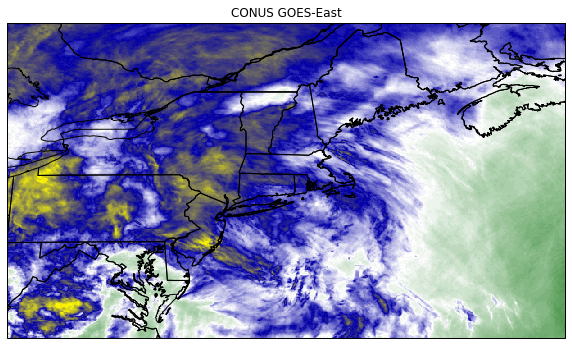

In [21]:
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'WVCIMSS'

# Create the MapPanel
panel = MapPanel()
panel.plots = [img]
panel.title = "CONUS GOES-East"
panel.area = 'ma'
panel.layers = ['coastline', 'borders', 'states']

# Create the PanelContainer
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)

# Show it!
pc.show()

You can also change the projection of the map to any of the cartopy coordinate reference systems. Set the *projection* attribute on the panel to the crs object.

In [22]:
import cartopy.crs as ccrs

In [23]:
# Explore ccrs with tab completion!

Finally, we can use `add_timestamp` from `metpy.plots` to add the image time to the image. We can even add the MetPy logo! To do that we need to get the axes object to work on and we need to get the image time from the metadata. This must be done after we've added the panel to the panel container so everything is associated correctly. Remember the flow is do the small things to the big things, then dress it up with annotations.

In [24]:
from metpy.plots import add_timestamp, add_metpy_logo

First we need to parse the datetime string into a datetime object that Python can work with.

In [25]:
print(ds.start_date_time)

2020011220617


In [26]:
start_time = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')

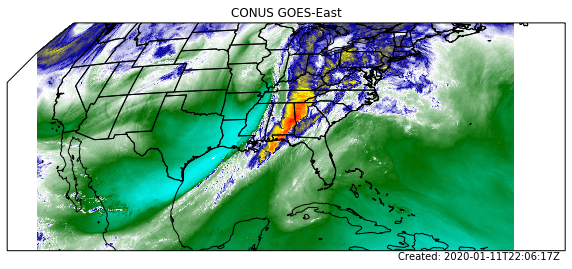

In [27]:
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'WVCIMSS'

# Create the MapPanel
panel = MapPanel()
panel.plots = [img]
panel.title = "CONUS GOES-East"
panel.area = 'us'
panel.layers = ['coastline', 'borders', 'states']

# Create the PanelContainer
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)

# Add Annotations
add_timestamp(panel.ax, start_time)

# Show it!
pc.show()


We can even highlight the text, change the "Created" pretext and make it look better still!

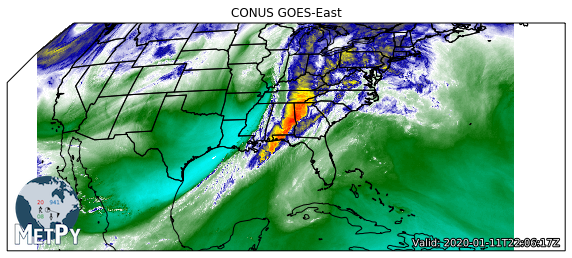

In [28]:
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'WVCIMSS'

# Create the MapPanel
panel = MapPanel()
panel.plots = [img]
panel.title = "CONUS GOES-East"
panel.area = 'us'
panel.layers = ['coastline', 'borders', 'states']

# Create the PanelContainer
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)

# Add Annotations
add_timestamp(panel.ax, start_time, high_contrast=True,
              pretext='Valid: ', y=0.02)

add_metpy_logo(pc.figure, y=10)

# Show it!
pc.show()


<a href="#pagetop">Top</a>
<hr style="height:2px;">